# 📌 Week 4 시계열 데이터 과제

- **구성:** 이론 + 실습  
- **이론:** 정규 세션 핵심 내용 기반 주관식 문제(총 2문제)
- **실습:** ARIMA & DLinear 모델 활용(총 4문제)
<br><br> 모르는 부분 혹은 문제에 오류가 있는 경우 편하게 연락해주세요:)

## 📖 이론
🔹 정규 세션에서 배운 핵심 개념을 바탕으로 한 **주관식 문제**입니다.  

**Q1**


- 시계열 데이터에서 추세와 계절성을 제거하면 정상성을 가지게 만들 수 있습니다. 이 때, 가법 모형과 승법 모형 각각에서 추세와 계절성을 추출하는 방법을 **간단하게** 서술해주세요.  <br><br>
참고: https://techblog-history-younghunjo1.tistory.com/81#google_vignette<br><br>

**A1**<br>

[가법 모델]<br>
추세: 시계열 y(t)를 이동평균 등으로 스무딩하여, 전반적인 경향선을 T(t)로 추정합니다.
<br>
계절성: 추세를 제거한 잔차 (y(t)−T(t))에서 같은 계절(예: 같은 달, 같은 요일)에 해당하는 값들의 평균 패턴을 추정해 S(t)로 정의합니다.
<br><br>
[승법 모델]<br>
추세:가법 모델과 마찬가지로 y(t)에 이동평균 혹은 다른 스무딩 기법을 적용해 T(t)를 추정합니다.
<br>
계절성:추세가 제거된 ‘비율’ (y(t)/T(t))을 구해, 특정 계절마다 평균 비율을 계절성 S(t)으로 잡습니다.

**Q2**

- AR(p) 및 MA(q) 모델을 차이점을 중심으로 설명해주세요.<br><br>

**A2**<br>

답: AR(p)는 과거 관측값들을 기반으로 현재 값(y(t))을 예측합니다. 반면 MA(q)은 과거 예측 오차(잔차)들을 활용해 현재 값(y(t))을 예측합니다. AR은 자기상관구조가 뚜렷한 데이터에, MA는 예측 잔차의 패턴이 강할 때 유용합니다

## 💻 실습1 ARIMA  
🔹 모의 데이터를 활용한 **ARIMA** 모델 실습입니다. 주어진 데이터를 활용하여 코드 중간중간 주어진 문제에 답해주세요.


### 데이터 전처리

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# 데이터 로드
df = pd.read_csv("/content/drive/MyDrive/tobigs/4주차/DailyDelhiClimateTrain.csv")
df_eval=pd.read_csv("/content/drive/MyDrive/tobigs/4주차/DailyDelhiClimateTest.csv")

# 데이터 확인
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [3]:
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

# 필요한 컬럼 선택 (meantemp)
df = df[["meantemp"]]

df_eval["date"] = pd.to_datetime(df_eval["date"])
df_eval.set_index("date", inplace=True)

# 필요한 컬럼 선택 (meantemp)
df_eval = df_eval[["meantemp"]]

df.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


### 정상성 확인

In [4]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# ADF 테스트 (단위근 검정) 수행
adf_result = adfuller(df["meantemp"])
adf_statistic, p_value = adf_result[0], adf_result[1]


# ADF 검정 결과 출력
adf_statistic, p_value

(np.float64(-2.021069055920673), np.float64(0.2774121372301602))

**Q1**

- 위 결과로부터 데이터가 정상성을 가지는지 답하고, 비정상성을 가진다면 어떤 처리를 할 수 있는지 **간단히** 서술해주세요,<br><br>

**A1**<br><br>
답: 데이터가 정상성을 가지려면 ADF 검정에서 유의수준 이하의 p-value가 나와야 하는데, 위 결과에서는 p-value가 0.277 정도로 비교적 크므로 비정상적이라고 볼 수 있습니다.
일반적으로 비정상 시계열에는 차분(differencing), 로그 변환(log transform), 혹은 추세·계절성 제거 등의 방법을 통해 정상성을 확보할 수 있습니다.


In [5]:
# 차분 진행
df_diff = df.diff().dropna()

# ADF 테스트 (차분 후)
adf_result_diff = adfuller(df_diff["meantemp"])
adf_statistic_diff, p_value_diff = adf_result_diff[0], adf_result_diff[1]

adf_statistic_diff, p_value_diff

(np.float64(-16.378720267074687), np.float64(2.764863137594565e-29))

### ARIMA 하이퍼 파라미터 결정

**Q2**

- 아래 ACF와 PACF Plot으로부터 ARIMA의 하이퍼파라미터인 p와 q를 몇으로 설정해야할지 그 숫자와 근거를 적어주세요. 이후 변수를 선언해주세요.<br><br>

**A2**<br>

p: 1
<br>
이유: p 값(AR 차수): 부분자기상관 함수(PACF) 그래프에서 1시차에서만 유의미한 스파이크가 보이고, 이후에는 신뢰구간 안에 들어가므로 보통 𝑝=1
p=1로 추정합니다.
<br><br>

q: 1
<br>
이유: q 값(MA 차수): 자기상관 함수(ACF) 그래프에서도 1시차에서만 뚜렷한 스파이크가 나타나고, 그 뒤는 크게 유의하지 않으므로 보통 𝑞=1
q=1로 추정합니다.

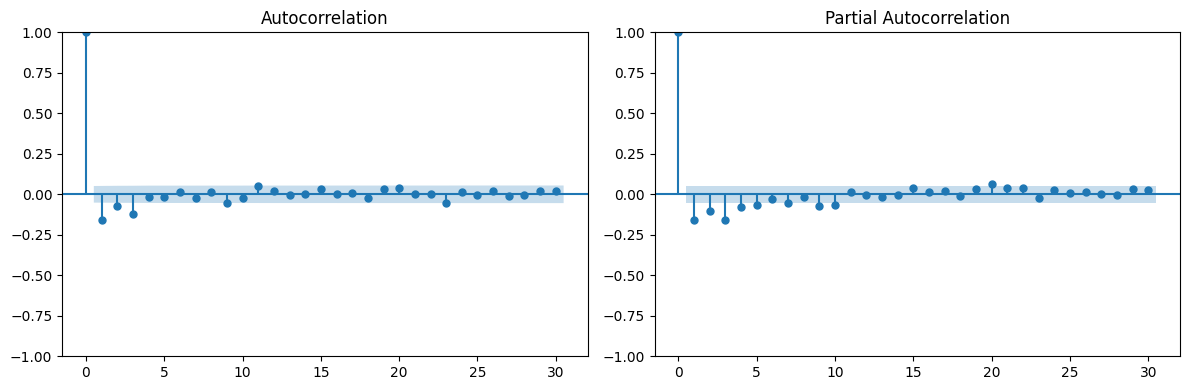

In [6]:
# ACF와 PACF 플롯
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sm.graphics.tsa.plot_acf(df_diff["meantemp"], lags=30, ax=axes[0])
sm.graphics.tsa.plot_pacf(df_diff["meantemp"], lags=30, ax=axes[1])

plt.tight_layout()
plt.show()


In [7]:
# 변수 선언

p=1
q=1

### ARIMA 학습

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
<ipython-input-8-524cadc9de22>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fitted"] = model_fit.fittedvalues


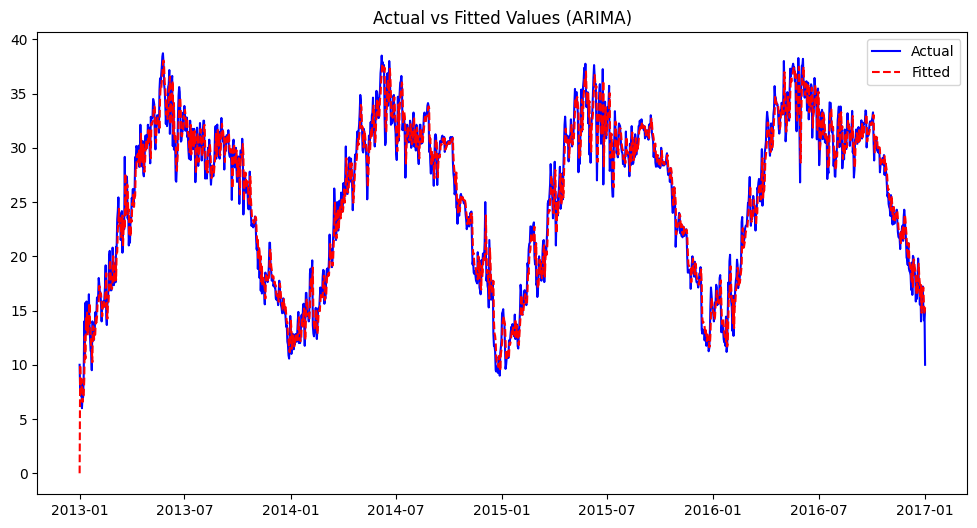

In [8]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df["meantemp"], order=(p, 1, q))
model_fit = model.fit()

# 예측 수행
df["fitted"] = model_fit.fittedvalues

# 실제값과 예측값 시각화
plt.figure(figsize=(12, 6))
plt.plot(df["meantemp"], label="Actual", color="blue")
plt.plot(df["fitted"], label="Fitted", color="red", linestyle="dashed")
plt.title("Actual vs Fitted Values (ARIMA)")
plt.legend()
plt.show()

In [48]:
np.average((df["meantemp"]-df['fitted'])/df["meantemp"]*100)


np.float64(-0.30974412718533206)

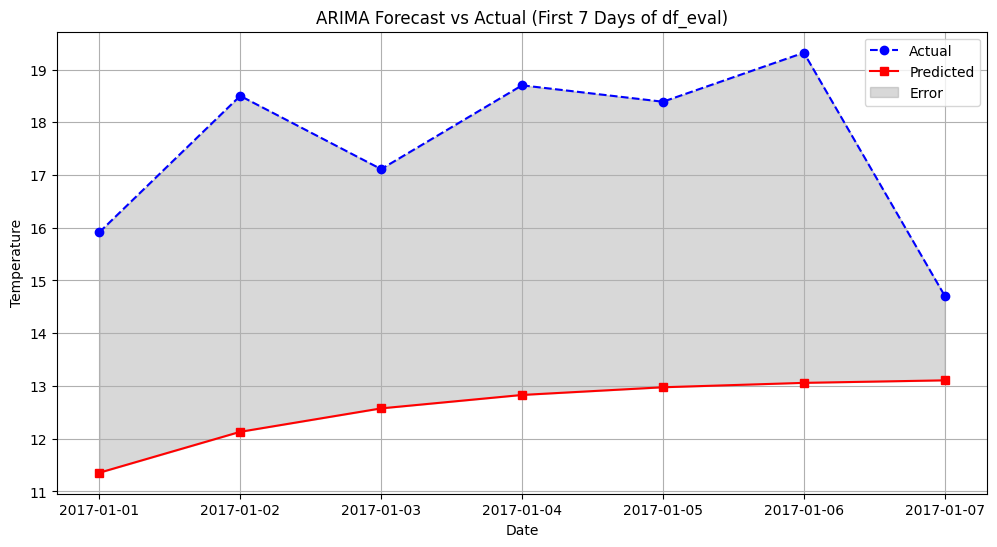

In [9]:
test_series = df_eval['meantemp'][:7]

forecast_steps = 7
forecast = model_fit.forecast(steps=forecast_steps)

plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series, label="Actual", linestyle="dashed", marker="o", color="blue")
plt.plot(test_series.index, forecast, label="Predicted", marker="s", color="red")
plt.fill_between(test_series.index, test_series, forecast, color="gray", alpha=0.3, label="Error")
plt.title("ARIMA Forecast vs Actual (First 7 Days of df_eval)")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()

### (선택) AutoARIMA

아래는 자동으로 p,d,q 값을 계산해주는 auto_arima를 사용한 코드입니다.

In [10]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.3 MB/s eta 0:00:00


In [11]:
from pmdarima import auto_arima

stepwise_model = auto_arima(df["meantemp"],
                            start_p=0, max_p=5,
                            start_q=0, max_q=5,
                            seasonal=False,
                            trace=True,  # 최적화 과정 출력
                            error_action="ignore",
                            suppress_warnings=True)

# 최적의 (p, d, q) 값 출력
print(f"\n Optimal (p, d, q): {stepwise_model.order}\n")

# 최적의 파라미터로 ARIMA 모델 학습
p, d, q = stepwise_model.order
model = ARIMA(df["meantemp"], order=(p, d, q))
model_fit = model.fit()

# 예측값 저장
df["fitted"] = model_fit.fittedvalues


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

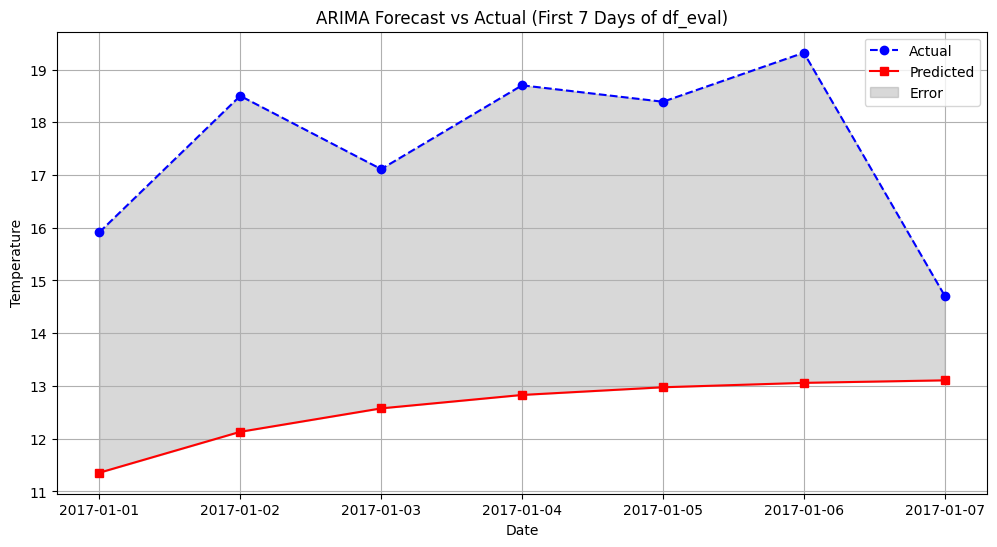

In [12]:
test_series = df_eval['meantemp'][:7]

forecast_steps = 7
forecast = model_fit.forecast(steps=forecast_steps)

plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series, label="Actual", linestyle="dashed", marker="o", color="blue")
plt.plot(test_series.index, forecast, label="Predicted", marker="s", color="red")
plt.fill_between(test_series.index, test_series, forecast, color="gray", alpha=0.3, label="Error")
plt.title("ARIMA Forecast vs Actual (First 7 Days of df_eval)")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()

## 💻 실습2 Dlinear

In [14]:
import pandas as pd
import numpy as np

# 데이터 로드
train_df = pd.read_csv('/content/drive/MyDrive/tobigs/4주차/DailyDelhiClimateTrain.csv')
test_df = pd.read_csv('/content/drive/MyDrive/tobigs/4주차/DailyDelhiClimateTest.csv')

# 날짜 컬럼을 제외한 데이터만 사용
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
train_df.set_index('date', inplace=True)
test_df.set_index('date', inplace=True)

features = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
train_values = train_df[features].values.astype(np.float32)
test_values = test_df[features].values.astype(np.float32)

**Q3**

- 30일간의 날씨 데이터를 이용해 7일 동안의 온도, 습도, 풍속, 대기압을 예측하고자 합니다. 아래 코드의 빈칸을 채워주세요. <br><br>


In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

# Sliding Window 전처리
def create_sequences(data, seq_len, pred_len):
    X, y = [], []
    for i in range(len(data) - seq_len - pred_len):
        X.append(data[i:i+seq_len]) # 빈칸을 채워주세요
        y.append(data[i+seq_len:i+seq_len+pred_len])  # 빈칸을 채워주세요
    return np.array(X), np.array(y)


seq_len = 30 # 빈칸을 채워주세요(예측을 위해 사용할 time step 수)
pred_len = 7 # 빈칸을 채워주세요(실제 예측할 time step 수)
X_train, y_train = create_sequences(train_values, seq_len, pred_len)


# PyTorch Dataset 정의
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

<ipython-input-21-ee6a4cc2bd08>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-21-ee6a4cc2bd08>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Dlinear 모델 선언

# 이동 평균을 이용한 추세 추출
class moving_avg(nn.Module):

    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size # Kernel: 이동 평균을 계산하기 위한 시간대의 길이
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

# 시계열 분해
class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean # 데이터에서 추세를 빼면 계절성 부분만 남음
        return res, moving_mean

# 모델
class Model(nn.Module):
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs['seq_len']
        self.pred_len = configs['pred_len']
        self.individual = configs['individual'] # 특성마다 다른 선형 회귀를 적용할지 여부
        self.channels = configs['enc_in'] # 입력 및 출력되는 특성 수

        # Decomposition Kernel Size
        kernel_size = configs['kernel_size'] # Kernel: 이동 평균을 계산하기 위한 시간대의 길이
        self.decompsition = series_decomp(kernel_size)

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len, self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len, self.pred_len))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len, self.pred_len)

    def forward(self, x):
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0, 2, 1), trend_init.permute(0, 2, 1)

        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.pred_len], dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.pred_len], dtype=trend_init.dtype).to(trend_init.device)

            for i in range(self.channels):
                seasonal_output[:, i, :] = self.Linear_Seasonal[i](seasonal_init[:, i, :])
                trend_output[:, i, :] = self.Linear_Trend[i](trend_init[:, i, :])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0, 2, 1)

**Q4**

- Dlinear 모델은 kernel, learning rate, individual, epoch 등 여러 하이퍼 파라미터가 존재합니다. 위의 하이퍼 파라미터를 직접 조정하시면서 평균 에러가 가장 낮게 나온 값을 작성해주세요. 마지막으로 ARIMA와 비교하여 어느 모델의 정확도가 더 높은 것 같은지 적어주세요.<br><br>

**A4**<br><br>
Kernel:  25
<br>
learning rate:  0.005
<br>
individual: True
<br>
epoch: 100
<br><br>
정확도가 더 높은 모델: Dlinear

In [43]:
# Kernel과 individual의 경우 configs 값을 조정해주세요

configs = {
    'seq_len': seq_len,
    'pred_len': pred_len,
    'individual': True,
    'enc_in': len(features),  # 모든 특성 사용
    'kernel_size': 25
}
model = Model(configs)
optimizer = optim.Adam(model.parameters(), lr=0.005) # learning rate 조절
loss_fn = nn.MSELoss()

# 모델 학습
num_epochs = 60 # epoch 조절
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = loss_fn(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/60, Loss: 29106.6400
Epoch 2/60, Loss: 10089.0397
Epoch 3/60, Loss: 9540.8866
Epoch 4/60, Loss: 9234.8393
Epoch 5/60, Loss: 9257.8976
Epoch 6/60, Loss: 9279.1336
Epoch 7/60, Loss: 9223.8244
Epoch 8/60, Loss: 9215.6053
Epoch 9/60, Loss: 9406.2211
Epoch 10/60, Loss: 9542.3675
Epoch 11/60, Loss: 9423.3929
Epoch 12/60, Loss: 9255.0059
Epoch 13/60, Loss: 9477.3058
Epoch 14/60, Loss: 9268.2703
Epoch 15/60, Loss: 9470.4244
Epoch 16/60, Loss: 9555.7508
Epoch 17/60, Loss: 9442.4218
Epoch 18/60, Loss: 9855.4249
Epoch 19/60, Loss: 9912.9979
Epoch 20/60, Loss: 9668.4949
Epoch 21/60, Loss: 9541.8842
Epoch 22/60, Loss: 9397.9391
Epoch 23/60, Loss: 9393.4890
Epoch 24/60, Loss: 9576.4254
Epoch 25/60, Loss: 9512.4786
Epoch 26/60, Loss: 9594.0778
Epoch 27/60, Loss: 9550.3846
Epoch 28/60, Loss: 9547.3922
Epoch 29/60, Loss: 9626.0593
Epoch 30/60, Loss: 9392.3790
Epoch 31/60, Loss: 9595.0245
Epoch 32/60, Loss: 9317.2614
Epoch 33/60, Loss: 9421.1644
Epoch 34/60, Loss: 9758.4589
Epoch 35/60, Loss: 93

평균 에러: 4.193032264709473


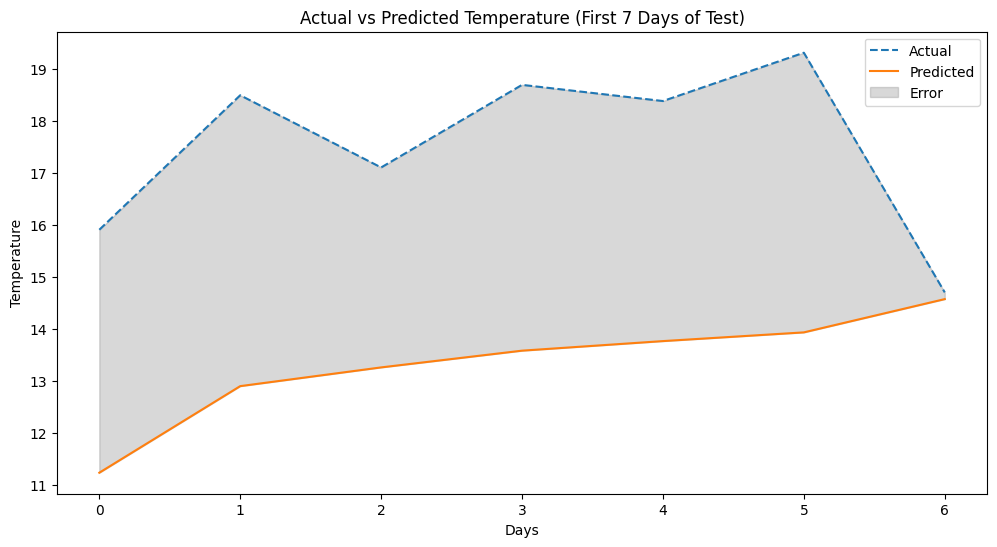

In [44]:
model.eval()
last_30_days = torch.tensor(train_values[-30:], dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    predictions = model(last_30_days).squeeze().numpy()

# 실제값 (온도만)
actuals = test_values[:7, 0]

# 예측값에서 온도만 선택
predictions_temp = predictions[:, 0]

# 차이 계산
error = actuals - predictions_temp

print(f"평균 에러: {error.mean()}")

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(7), actuals, label='Actual', linestyle='dashed')
plt.plot(range(7), predictions_temp, label='Predicted')
plt.fill_between(range(7), actuals, predictions_temp, color='gray', alpha=0.3, label='Error')
plt.title('Actual vs Predicted Temperature (First 7 Days of Test)')
plt.xlabel('Days')
plt.ylabel('Temperature')
plt.legend()
plt.show()

👏 **수고 많았습니다! 다음 과제도 화이팅! 🚀**